In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
import scipy
# Define original and target coordinates
original_extent = (-25, 25, -25, 25)  # (xmin, xmax, ymin, ymax)
target_extent = (-2, 5, -2, 2)        # (xmin, xmax, ymin, ymax)
source_position = (-2, 0)             # Where to place the source


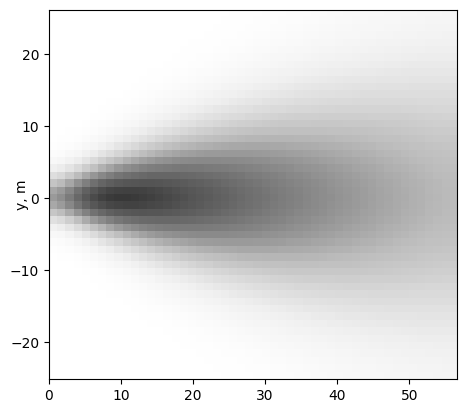

In [12]:
dirname = ('/home/vbl/gazebo_ws/src/gazebo_px4_simulator/odor_sim_assets/hws/')
hmap_data = np.load(str(dirname) + "hmap.npz")
fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

fitted_p_heatmap=hmap_data['fitted_heatmap']
xedges=hmap_data['xedges']
yedges=hmap_data['yedges']

f,ax=plt.subplots(1,1)
cax = ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Greys', vmin=0, vmax=0.01, rasterized=True,
)
ax.set_rasterization_zorder(-20)

# ax.set_xlabel('Distance along Streakline, m')
# ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_ylabel('y, m')
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.ticklabel_format(useOffset=False)

# ax.set_ylim(-40,50)
ax.grid(False)

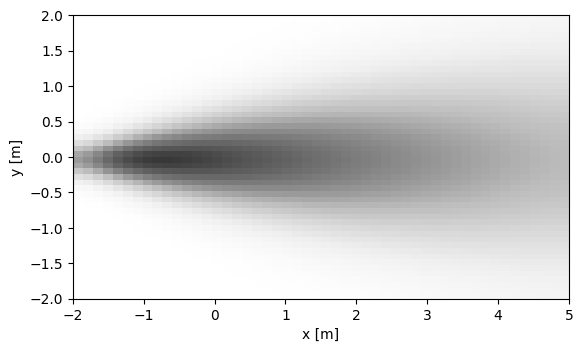

In [16]:

# 1) compute scale factors and shifted edges
old_xmin, old_xmax = xedges[0], xedges[-1]
old_ymin, old_ymax = yedges[0], yedges[-1]

# For the example, assume source at 0 in old coords => shift & scale so that
# old_x=0 maps to new_x=-2, and old_x=old_xmax maps to new_x=5.
new_xmin, new_xmax = -2, 5
scale_x = (new_xmax - new_xmin) / (old_xmax - old_xmin)

# Similarly for y from -2..2
new_ymin, new_ymax = -2, 2
scale_y = (new_ymax - new_ymin) / (old_ymax - old_ymin)

# Apply to all edges
scaled_xedges = new_xmin + scale_x * (xedges - old_xmin)
scaled_yedges = new_ymin + scale_y * (yedges - old_ymin)

# Now just use these in 'extent'
plt.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[scaled_xedges[0], scaled_xedges[-1],
            scaled_yedges[0], scaled_yedges[-1]],
    cmap='Greys', vmin=0, vmax=0.01,
    rasterized=True,
)

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

In [27]:
# np.savez('rescaled_odor_heatmap.npz', 
#          fitted_heatmap=fitted_p_heatmap,
#          xedges=scaled_xedges, 
#          yedges=scaled_yedges)


fdf = pd.read_hdf('/home/vbl/gazebo_ws/src/gazebo_px4_simulator/odor_sim_assets/hws/nowhiff.h5')

In [30]:
fdf.keys()

Index(['wc_nowhiff', 'wsd_nowhiff', 'avg_distance_along_streakline',
       'avg_nearest_from_streakline', 'avg_dist_from_source'],
      dtype='object')

In [29]:
# Define old bounding box
xmin_old, xmax_old = 0, 60
ymin_old, ymax_old = -20, 20

# Define new bounding box + new source
xmin_new, xmax_new = -2, 5
ymin_new, ymax_new = -2, 2
source_new = (-2, 0)

# Scale factors
scale_x = (xmax_new - xmin_new) / (xmax_old - xmin_old)
scale_y = (ymax_new - ymin_new) / (ymax_old - ymin_old)

# In many streakline analyses:
# avg_distance_along_streakline ~ x-coordinate
# avg_nearest_from_streakline   ~ y-offset
# So let's treat them as (bar_x, bar_y)
bar_x_old = fdf["avg_distance_along_streakline"].values
bar_y_old = fdf["avg_nearest_from_streakline"].values

# Now compute the new coordinates
x_new = xmin_new + scale_x * (bar_x_old - xmin_old)
y_new = ymin_new + scale_y * (bar_y_old - ymin_old)

# Recompute distance from NEW source = sqrt( (x_new - xS)^2 + (y_new - yS)^2 )
xS, yS = source_new
dist_new = np.sqrt((x_new - xS)**2 + (y_new - yS)**2)

# Store them in new columns if you like:
fdf["avg_distance_along_streakline"] = x_new
fdf["avg_nearest_from_streakline"]   = y_new
fdf["avg_dist_from_source"]          = dist_new

In [31]:
fdf.to_hdf('/home/vbl/gazebo_ws/src/gazebo_px4_simulator/odor_sim_assets/hws/nowhiff_rescaled.h5', key='fdf', mode='w')